In [1]:
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir(os.pardir)

import matplotlib.pyplot as plt
import numpy as np

from src.utils.dataloader import load_ear_data
from src.utils.viz import set_axes_equal

In [2]:
def clean_df(df):
    df = df[(df['x [mm]'] != df['x [mm]'].min())
            & (df['x [mm]'] != df['x [mm]'].max())
            & (df['y [mm]'] != df['y [mm]'].min())
            & (df['y [mm]'] != df['y [mm]'].max())
            & (df['z [mm]'] != df['z [mm]'].min())
            & (df['z [mm]'] != df['z [mm]'].max())]
    df.reset_index(drop=True, inplace=True)
    return df


def export_pcd(df, area=False):
    if area:
        pcd = np.c_[df['x [mm]'].to_numpy(),
                    df['y [mm]'].to_numpy(),
                    df['z [mm]'].to_numpy(),
                    df['area [mm^2]'].to_numpy()]
    else:
        pcd = np.c_[df['x [mm]'].to_numpy(),
                    df['y [mm]'].to_numpy(),
                    df['z [mm]'].to_numpy()]
    return pcd


def export_fields(df):
    Ex = df['ExRe [V/m]'].to_numpy() + 1j * df['ExIm [V/m]'].to_numpy()
    Ey = df['EyRe [V/m]'].to_numpy() + 1j * df['EyIm [V/m]'].to_numpy()
    Ez = df['EzRe [V/m]'].to_numpy() + 1j * df['EzIm [V/m]'].to_numpy()
    Hx = df['HxRe [A/m]'].to_numpy() + 1j * df['HxIm [A/m]'].to_numpy()
    Hy = df['HyRe [A/m]'].to_numpy() + 1j * df['HyIm [A/m]'].to_numpy()
    Hz = df['HzRe [A/m]'].to_numpy() + 1j * df['HzIm [A/m]'].to_numpy()
    return (Ex, Ey, Ez), (Hx, Hy, Hz)


def poynting_vector(E, H):
    Sx = 0.5 * (E[1] * H[2].conjugate() - E[2] * H[1].conjugate())
    Sy = 0.5 * (E[2] * H[0].conjugate() - E[0] * H[2].conjugate())
    Sz = 0.5 * (E[0] * H[1].conjugate() - E[1] * H[0].conjugate())
    return Sx, Sy, Sz


def prettify_viz():
    import seaborn as sns
    sns.set(style='ticks', palette='colorblind')
    %config InlineBackend.figure_format = 'retina'


def plot_2d(xy_dict, figsize=plt.rcParams['figure.figsize'], c=None, alpha=1):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    keys = list(xy_dict.keys())
    values = list(xy_dict.values())
    if (len(values) == 3) and not(c):
        cs = ax.scatter(values[0], values[1], c=values[2], cmap='viridis')
        cbar = fig.colorbar(cs)
        cbar.ax.set_ylabel(keys[2])
    else:
        if not(c):
            c = 'k'
        cs = ax.scatter(values[0], values[1], c=c, alpha=alpha)
    ax.set(xlabel=keys[0], ylabel=keys[1])
    
    ax.axis('equal')
    fig.tight_layout()
    return fig, ax


def plot_3d(xyz_dict, figsize=(7, 7), elev=[20], azim=[45], c=None, alpha=1):
    from itertools import product
    num_figs = len(elev) * len(azim)
    if num_figs > 4:
        raise ValueError('The max number of subplots is 4.')
    if num_figs != 1:
        figsize = (figsize[0] * num_figs / 2, figsize[1] * num_figs / 2)
    fig = plt.figure(figsize=figsize)
    keys = list(xyz_dict.keys())
    values = list(xyz_dict.values())
    for i, (e, a) in enumerate(product(elev, azim)):
        ax = fig.add_subplot(num_figs, 1, i+1, projection='3d')
        if (len(values) == 4) and not(c):
            cs = ax.scatter(values[0], values[1], values[2],
                            c=values[3], cmap='viridis')
            cbar = fig.colorbar(cs, shrink=0.5, pad=0.1)
            cbar.ax.set_ylabel(keys[3])
        else:
            if not(c):
                c = 'k'
            cs = ax.plot(values[0], values[1], values[2], '.', c=c, alpha=alpha)
        ax.set(xlabel=keys[0], ylabel=keys[1], zlabel=keys[2])
        ax = set_axes_equal(ax)
        ax.view_init(elev=e, azim=a)
    fig.tight_layout()
    return fig, ax


def minmax_scale(x, _range=(0, 1)):
    scaler = (x - x.min()) / (x.max() - x.min())
    x_scaled = scaler * (_range[1] - _range[0]) + _range[0]
    return x_scaled


def colormap_from_array(x, cmap='viridis', alpha=None, bytes=False):
    from matplotlib import cm
    x_scaled = minmax_scale(x)
    try:
        cs = eval(f'cm.{cmap}')(x_scaled, alpha, bytes)
    except Exception as e:
        print(e, 'Falling to default colormap')
        cs = cm.viridis(x_scaled, alpha, bytes)
    finally:
        if alpha is None:
            cs = cs[:, :3]
    return cs


def estimate_normals(xyz, take_every=1, knn=30, fast=True):
    import open3d as o3d
    xyz = xyz[::take_every, :]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn),
                         fast_normal_computation=fast)
    pcd.normalize_normals()
    n = np.asarray(pcd.normals)
    return n

In [3]:
prettify_viz()

In [4]:
PROJECT_NAME = 'IMBioC2022_paper'

In [5]:
df = load_ear_data('te', 60)
df = clean_df(df)
df

,x [mm],y [mm],z [mm],ExRe [V/m],ExIm [V/m],EyRe [V/m],EyIm [V/m],EzRe [V/m],EzIm [V/m],HxRe [A/m],HxIm [A/m],HyRe [A/m],HyIm [A/m],HzRe [A/m],HzIm [A/m],area [mm^2]
0,68.086311,-2.688804,6.271268,1.232110,-5.230014,-0.854390,-2.007048,-1.674893,1.056376,-0.003978,0.015257,0.006635,0.069231,0.012686,0.013412,0.021413
1,68.137262,-1.882788,6.271268,0.110677,-4.952678,0.181903,1.913511,0.233148,-0.185610,0.012695,0.016883,0.020533,0.040169,0.001112,0.000054,0.021204
2,68.137262,-1.661499,6.271268,-0.158298,-4.748529,0.768468,1.654867,0.411543,-0.230130,0.016060,0.011812,0.020303,0.035178,0.000582,0.001067,0.021204
3,68.137262,-1.440210,6.271268,-0.433497,-4.280247,1.174487,1.214872,0.532638,-0.263018,0.017855,0.005253,0.020103,0.031797,0.001083,0.001507,0.021204
4,68.137262,-1.218921,6.271268,-0.632277,-4.512611,1.366378,0.712167,0.600204,-0.543568,0.016926,-0.000357,0.019053,0.030942,0.001624,0.001248,0.021204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235895,78.963859,23.625316,-19.634544,-54.406391,50.005753,-1.355134,1.343070,-4.986677,-7.405610,0.003381,-0.002889,-0.145401,0.135739,-0.001949,0.003562,0.018991
235896,78.991476,23.313006,-19.562917,-49.443726,55.848423,-0.922195,0.994825,-6.457432,-6.518611,0.002314,-0.002010,-0.132701,0.148280,-0.000963,0.002942,0.021192
235897,79.020337,23.324603,-19.438831,-39.981647,64.021866,-0.715655,1.295890,-8.591330,-3.589297,0.002183,-0.002558,-0.107785,0.166156,-0.001015,0.003337,0.021145
235898,79.010733,23.544151,-19.453349,-41.346844,63.000320,-1.009556,1.707334,-8.313073,-3.887859,0.002853,-0.003285,-0.110526,0.163981,-0.001588,0.003888,0.020441


In [6]:
xyz = export_pcd(df)
E, H = export_fields(df)

In [7]:
Sx, Sy, Sz = poynting_vector(E, H)

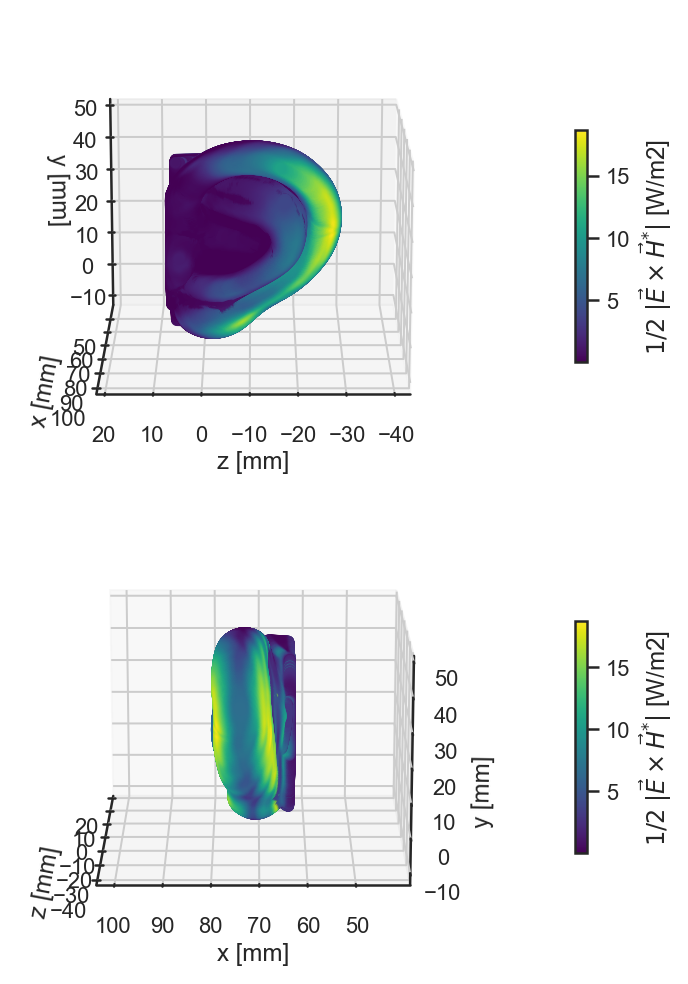

In [8]:
S = abs(np.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2))
S_label = r'$1/2$ $|\vec{E}\times\vec{H}^{*}|$ [W/m2]'
fig, ax = plot_3d({'z [mm]': xyz[:, 2],
                   'x [mm]': xyz[:, 0],
                   'y [mm]': xyz[:, 1],
                   S_label: S},
                  elev=[15], azim=[90, 180])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


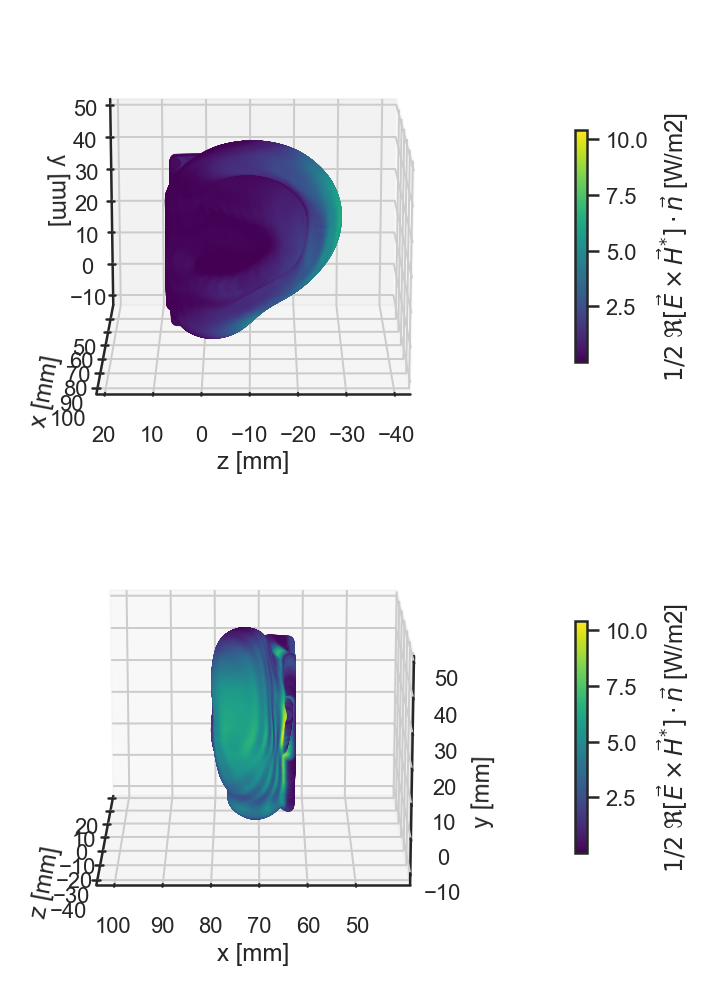

In [9]:
n = estimate_normals(xyz, knn=30, fast=True)
Sr = abs(Sx.real * n[:, 0] + Sy.real * n[:, 1] + Sz.real * n[:, 2])
Sr_label = r'$1/2$ $\Re{[\vec{E}\times\vec{H}^{*}]} \cdot \vec{n}$ [W/m2]'
fig, ax = plot_3d({'z [mm]': xyz[:, 2],
                   'x [mm]': xyz[:, 0],
                   'y [mm]': xyz[:, 1],
                   Sr_label: Sr},
                  elev=[15], azim=[90, 180])

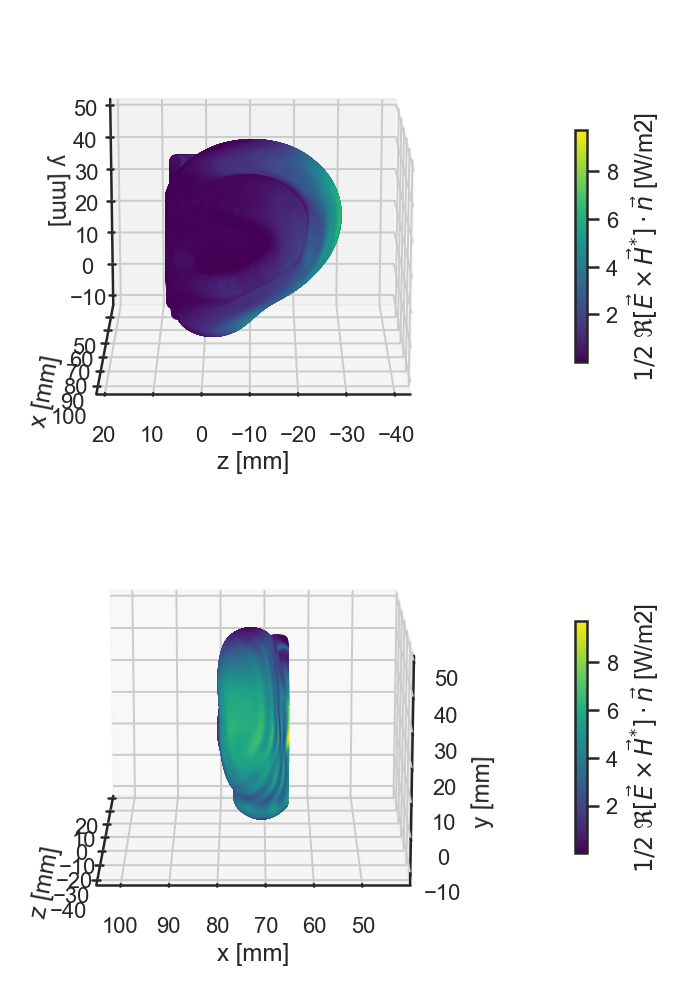

In [10]:
crop_idxs = np.where(xyz[:, 0] > 66)[0]
xyz_crop = xyz[crop_idxs]
Sx_crop, Sy_crop, Sz_crop = Sx[crop_idxs], Sy[crop_idxs], Sz[crop_idxs]
n_crop = estimate_normals(xyz_crop, knn=30, fast=True)
Sr_crop = abs(Sx_crop.real * n_crop[:, 0]
              + Sy_crop.real * n_crop[:, 1]
              + Sz_crop.real * n_crop[:, 2])
fig, ax = plot_3d({'z [mm]': xyz_crop[:, 2],
                   'x [mm]': xyz_crop[:, 0],
                   'y [mm]': xyz_crop[:, 1],
                   Sr_label: Sr_crop},
                  elev=[15], azim=[90, 180])

In [11]:
# experimental
import open3d as o3d

# copy the data
points = xyz.copy()
normals = n.copy()
APD = Sr.copy()

In [12]:
# define coordinate frame
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10,
                                                           origin=[0] * 3)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([pcd, cframe])

In [13]:
# translate data to have a center at (0, 0, 0)
center = pcd.get_center()
xyz_t = np.c_[points[:, 0] - center[0],
              points[:, 1] - center[1],
              points[:, 2] - center[2]]
pcd_t = o3d.geometry.PointCloud()
pcd_t.points = o3d.utility.Vector3dVector(xyz_t)
pcd_t.paint_uniform_color([0.5, 0.5, 0.5])
o3d.visualization.draw_geometries([pcd_t, cframe])

In [14]:
# select xs-visible indices
diameter = np.linalg.norm(pcd_t.get_max_bound() - pcd_t.get_min_bound())
radius = 10 ** 5.5
camera = [diameter, 0, 0]

_, pt_map = pcd_t.hidden_point_removal(camera, radius)

xyz_t_zy_plane = xyz_t[pt_map]
APD_t_zy_plane = APD[pt_map]
pcd_t_zy_plane = o3d.geometry.PointCloud()
pcd_t_zy_plane.points = o3d.utility.Vector3dVector(xyz_t_zy_plane)
pcd_t_zy_plane.colors = o3d.utility.Vector3dVector(colormap_from_array(APD_t_zy_plane))
o3d.visualization.draw_geometries([pcd_t_zy_plane, cframe])

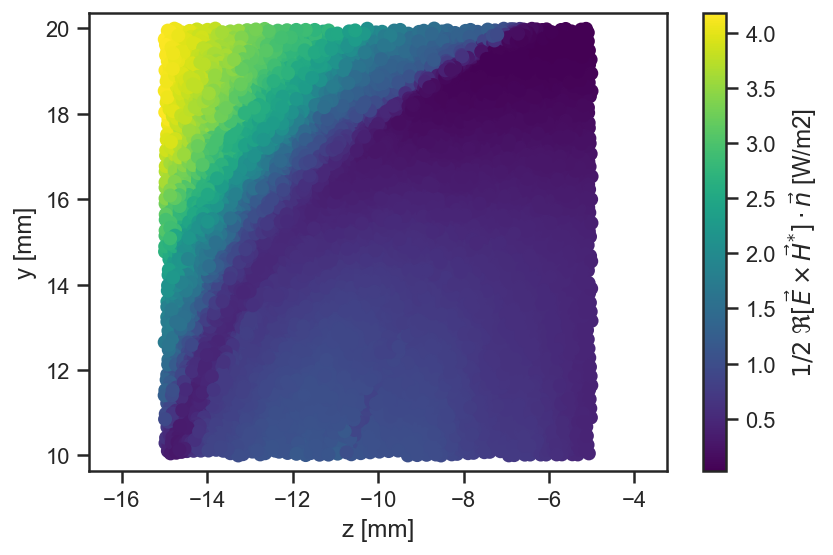

In [18]:
# create target suface area for averaging
z_bound = [-15, -5]
y_bound = [10, 20]
area = (z_bound[1] - z_bound[0]) * (y_bound[1] - y_bound[0])
idx_target = np.where((xyz_t_zy_plane[:, 2] > z_bound[0])
                      & (xyz_t_zy_plane[:, 2] < z_bound[1])
                      & (xyz_t_zy_plane[:, 1] > y_bound[0])
                      & (xyz_t_zy_plane[:, 1] < y_bound[1]))[0]
xyz_target = xyz_t_zy_plane[idx_target]
APD_target = APD_t_zy_plane[idx_target]

fig, ax = plot_2d({'z [mm]': xyz_target[:, 2],
                   'y [mm]': xyz_target[:, 1],
                   Sr_label: APD_target})

In [20]:
from src.utils.integrate import elementwise_dblquad
APD_avg = 1 / area * elementwise_dblquad(points=np.c_[xyz_target[:, 2], xyz_target[:, 1]],
                                         values=APD_target,
                                         leggauss_deg=51)
APD_avg

1.011219672514393